# Trotterization with light-cone ordering (short-time)

In [27]:
from qiskit.quantum_info import SparsePauliOp, random_statevector
from functools import partial
import multiprocessing
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy, jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
from spin_ham import *
from trotter import *
from bounds import *
from dqpt  import *

figs_dir, data_dir = './figs', './data'


plt.rc('axes', labelsize=LARGE_SIZE+3)  # fontsize of the x and y labels
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 2.0


## Nearest-neighbor Heisenberg model

In [42]:
prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 400 # 400,  100,  200,  250
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198, 248, 310]
n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198, 248, 310]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198, 248]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161]
# n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130]
# n_list_bnd = []
# n_list_bnd = [199, 249]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199, 249]
r_max = n_bnd_max
n_max, n_min = 12, 6  #  9, 5 ;  12, 5 
# n_max, n_min = 10, 5  #  9, 5 ;  12, 5 
# J, h = 1, 1 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
J, h, g = 1, 0.5, 1.2 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
# J, h, g = 1, 0.5, 0.8 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
t, eps = 0.1, 0.001
# t, eps = 0.2, 0.005

field_list = [0 for _ in range(n_bnd_max)]
# field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
# print('random field: ', field_list)
n_list_emp = np.arange(n_min, n_max+1)
print('n_list_emp: ', n_list_emp)

n_list_emp:  [ 6  7  8  9 10 11 12]


In [110]:
data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = 1, 1, 1
r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_max-1, r_max-1, r_max-1

import multiprocess as mp
PROCESSES = 10
for i, n in enumerate(n_list_bnd):
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=h, hy=g, hz=0, pbc=False, rand_field=field_list)
    # r_start, r_end = 1, int(n/2)
    print(f'-------------- n (bound) = {n} --------------')
    bnd_worst_err_r = partial(measure_error, h_list=hnn.ham_xyz[:2], t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    
    r_worst_bnd = binary_search_r(r_start_worst_bnd, r_end_worst_bnd, eps, bnd_worst_err_r, comment='worst_bnd',verbose=True)
    r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_worst_bnd+10, r_worst_bnd, r_worst_bnd
    # bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, tail_cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    right, left = 0, 0
    print('prepare single ob table...')
    def singl_ob_cmm(j):
        h_list_z = lc_group(hnn, right, left, 2*j, verbose=False, legacy=True)
        c1_cmm_z, c2_cmm_z = nested_commutator_norm(h_list_z)
        return c1_cmm_z, c2_cmm_z
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        singl_data= pool.map(singl_ob_cmm, range(1, r_end_singl_bnd+1))
    # print('singl_data: ', singl_data)

    print('prepare multi ob table...')
    def multi_z_cmm(j):
        # h_list_z_list = [lc_group(hnn, i, i, 2*j+2, verbose=False) for i in range(0, n)]
        h_list_zz_list = [lc_group(hnn, i, i+1, 2*j+2, verbose=False) for i in range(0, n-1)]
        # tail_cmm_data = np.array([nested_commutator_norm(h_list_z) for h_list_z in h_list_z_list])
        tail_cmm_data = np.array([nested_commutator_norm(h_list_zz) for h_list_zz in h_list_zz_list])
        return tail_cmm_data
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        multi_z_data= pool.map(multi_z_cmm, range(1, r_end_multi_bnd+1))
    # print('multi_z_data: ', multi_z_data)
    # print(r_end_singl_bnd, r_end_multi_bnd)

    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    # bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_zz', n, hnn, 0, 0])
    bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['singl', n, singl_data])
    bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['multi_zz', n, multi_z_data])

    r_singl_bnd = binary_search_r(r_start_singl_bnd, r_end_singl_bnd, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
    r_multi_bnd = binary_search_r(r_start_multi_bnd, r_end_multi_bnd, eps, bnd_multi_err_r, comment='multi_bnd',verbose=True)
    bnd_data['worst'].append(r_worst_bnd)
    bnd_data['singl'].append(r_singl_bnd)
    bnd_data['multi'].append(r_multi_bnd)
    r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = r_worst_bnd, r_singl_bnd, r_multi_bnd

r_start_worst_emp, r_start_singl_emp, r_start_multi_emp, r_end = 1, 1, 1, r_max-1
for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=h, hy=g, hz=0, pbc=False, rand_field=field_list)
    # field_list = hnn.rand_field
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Y', [i], 1) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n).to_matrix()
    multi_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    # par_group = [h.to_matrix() for h in hnn.ham_par][::-1]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    r_worst_emp = binary_search_r(r_start_worst_emp, r_end, eps, emp_worst_err_r, comment='worst_emp', verbose=True)
    r_singl_emp = binary_search_r(r_start_singl_emp, r_end, eps, emp_singl_err_r, comment='singl_emp',verbose=True)
    r_multi_emp = binary_search_r(r_start_multi_emp, r_end, eps, emp_multi_err_r, comment='multi_emp',verbose=True)
    emp_data['worst'].append(r_worst_emp)
    emp_data['singl'].append(r_singl_emp)
    emp_data['multi'].append(r_multi_emp)
    r_start_worst_emp, r_start_singl_emp, r_start_multi_emp = r_worst_emp, r_singl_emp, r_multi_emp

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data)

-------------- n (bound) = 6 --------------
----[worst_bnd] binary search r (r_start=1, r_end=399)----
r_start: 1 ; r_end: 200
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 5 ; r_end: 7
r_start: 5 ; r_end: 6
r: 6 ; err:  0.0009622222222222222
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=1, r_end=6)----
r_start: 3 ; r_end: 6
r_start: 3 ; r_end: 4
r: 4 ; err:  0.0007956249999999999
----[multi_bnd] binary search r (r_start=1, r_end=6)----
r_start: 3 ; r_end: 6
r_start: 4 ; r_end: 6
r_start: 4 ; r_end: 5
r: 5 ; err:  0.0006456000000000001
-------------- n (bound) = 7 --------------
----[worst_bnd] binary search r (r_start=6, r_end=16)----
r_start: 6 ; r_end: 11
r_start: 6 ; r_end: 8
r_start: 6 ; r_end: 7
r: 7 ; err:  0.0008530612244897961
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=4, r_end=7)-

,worst,singl,multi,n
0,6,4,5,6
1,7,4,5,7
2,7,4,5,8
3,8,5,5,9
4,8,5,6,10
5,9,5,6,12
6,10,5,6,15
7,11,5,7,18
8,13,5,7,23
9,15,5,8,29


    worst  singl  multi    n
0       6      4      5    6
1       7      4      5    7
2       7      4      5    8
3       8      5      5    9
4       8      5      6   10
5       9      5      6   12
6      10      5      6   15
7      11      5      7   18
8      13      5      7   23
9      15      5      8   29
10     16      5      8   36
11     18      5      8   44
12     20      5      9   55
13     22      5      9   68
14     25      5      9   84
15     28      5      9  105
16     31      5      9  130
17     34      5      9  161
a_em: 1.5231678257233852; b_em: 2.975523059771599
a_em: 1.9423407649089323e-08; b_em: 5.438079225175517
a_em: 1.078276042721255; b_em: 3.9083999131528557
a_em: -7.336830698534413e-09; b_em: 3.784189655674295
a_em: 0.9999999999999988; b_em: 2.7725887222397834


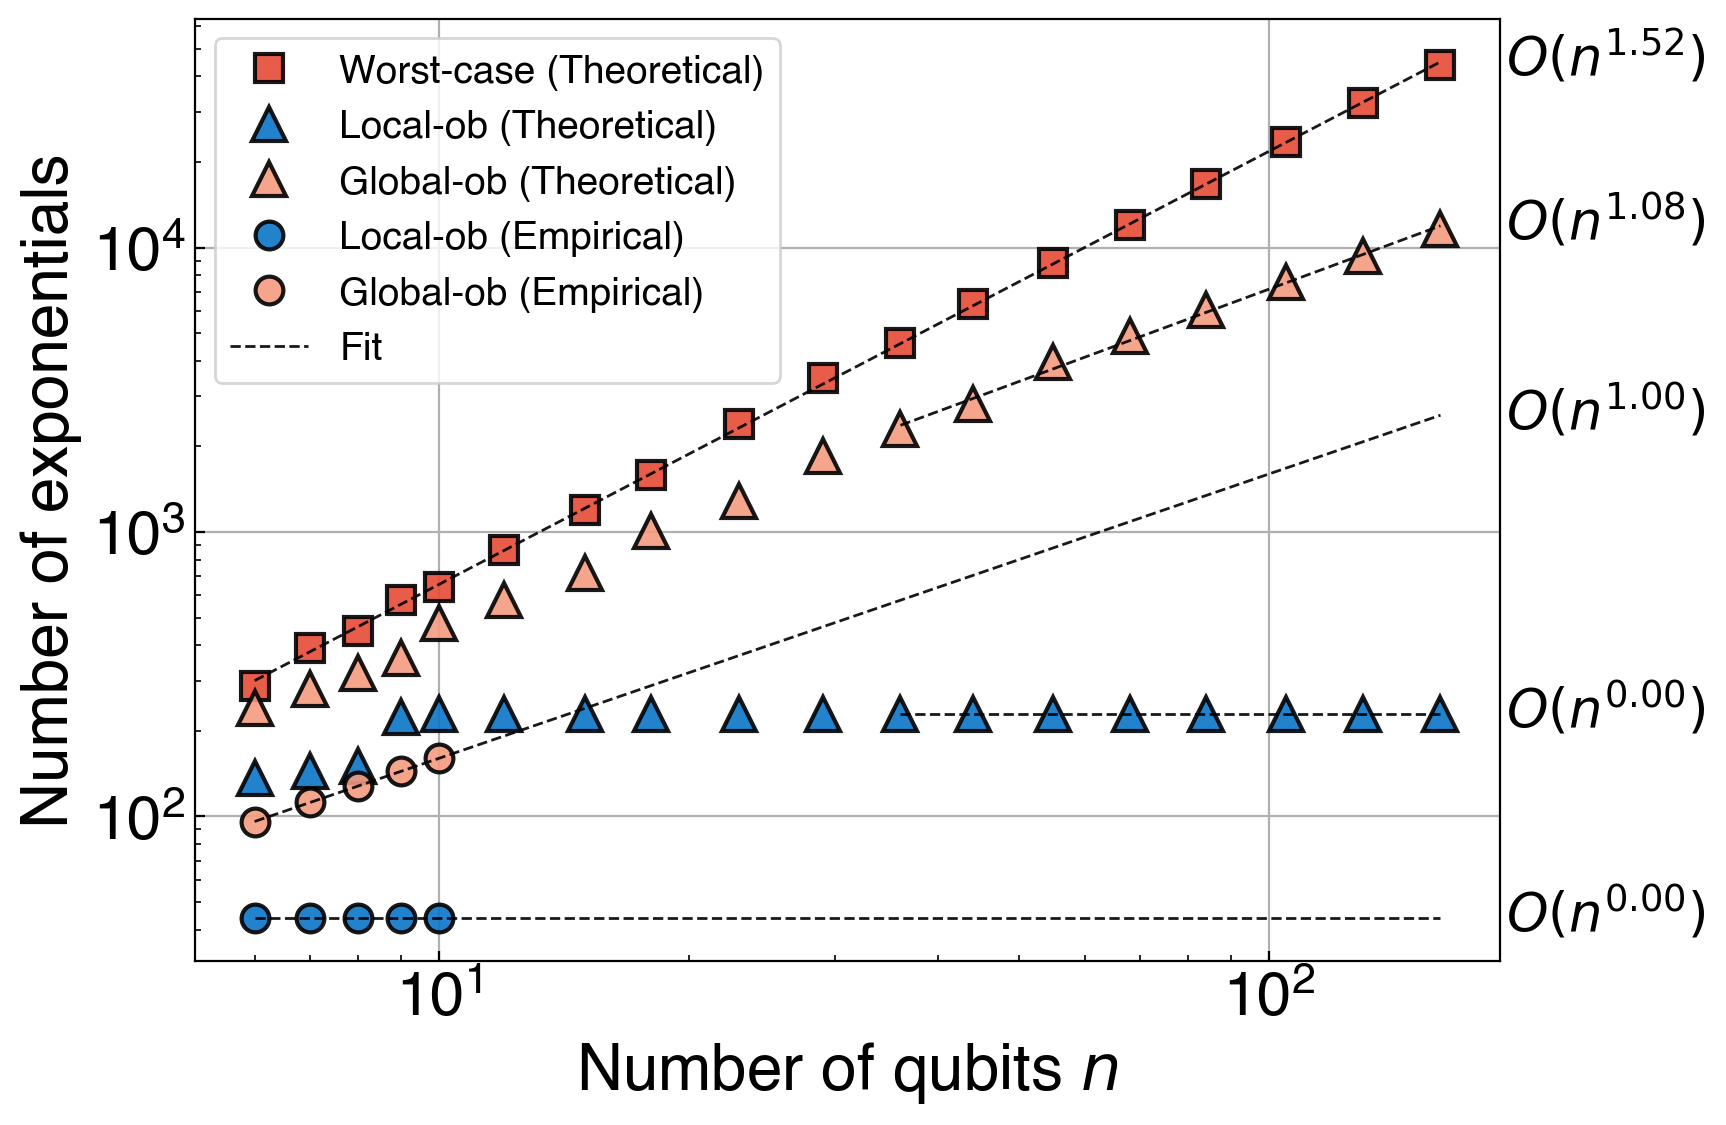

In [4]:
plt.rc('legend', fontsize=MEDIUM_SIZE-1) 
markersize_shift = 0
mpl.rcParams['lines.markersize'] = 10

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

# emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
# bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
# emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_max=9_bnd_max=200_{suffix}.csv')
# bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_max=9_bnd_max=200_{suffix}.csv')
print(bnd_data)

def exp_count_LC(r, n_qubits, n_terms):
    exp_count = 0
    for i in range(1, r+1):
        # print('i: ', i)
        if i < int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2    
            # exp_count += (4 * i - 1) * 2    
        elif i == int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2  - 1
        else:
            exp_count += n_terms * 2
    return exp_count

cost_st_list = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count_LC(r, bnd_data['n'][i], factor*bnd_data['n'][i]) for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count_LC(r, emp_data['n'][i], factor*emp_data['n'][i]) for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['multi'])]
cost_em_list_w =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['worst'])]

# n_list_bnd = bnd_data['n']
# n_list_emp = emp_data['n']
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199, 249]
# n_list_emp = np.arange(5, 9+1)
# ext_n = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199, 249]

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10-markersize_shift)
plot_fit(ax2, n_list_bnd[0:], cost_st_list[0:], var=suffix, x_offset=1.20, y_offset=0.9)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color='#0A75C7', label='Local-ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-8:], cost_lc_list_s[-8:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color='#F39B7FFF', label='Global-ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-8:], cost_lc_list_m[-8:], var=suffix, x_offset=1.20, y_offset=0.9)
# plot_fit(ax2, n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
# ax2.plot(n_list_emp, cost_em_list_w, 'D', color='#E64B35FF', label=r'Worst-case (Empirical)', markersize=10)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color='#0A75C7', label='Local-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.20, y_offset=0.9, ext_x=n_list_bnd)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color='#F39B7FFF', label='Global-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.20, y_offset=0.9, ext_x=n_list_bnd, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel(f'Number of qubits $n$')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog(); 
# ax2.set_xscale('log', base=20)
# ax2.set_yscale('log', base=10)
ax2.grid(); ax2.legend(loc='upper left')
fig.savefig(f'{figs_dir}/lightcone_NNH1d_J={J}_h={h}_n={n_list_emp[-1]}_nbnd={n_list_bnd[-1]}_eps={eps}_t={t}_2r.pdf', bbox_inches='tight')

a_em: 1.4811354219006534; b_em: 2.661269991471266
a_em: 1.828223736801062e-08; b_em: 5.023880443677701
a_em: 1.065866586335896; b_em: 3.8617856166440294
a_em: -4.006833287431764e-08; b_em: 3.7841897170322034
a_em: 0.9999999999999964; b_em: 2.7725887222397887


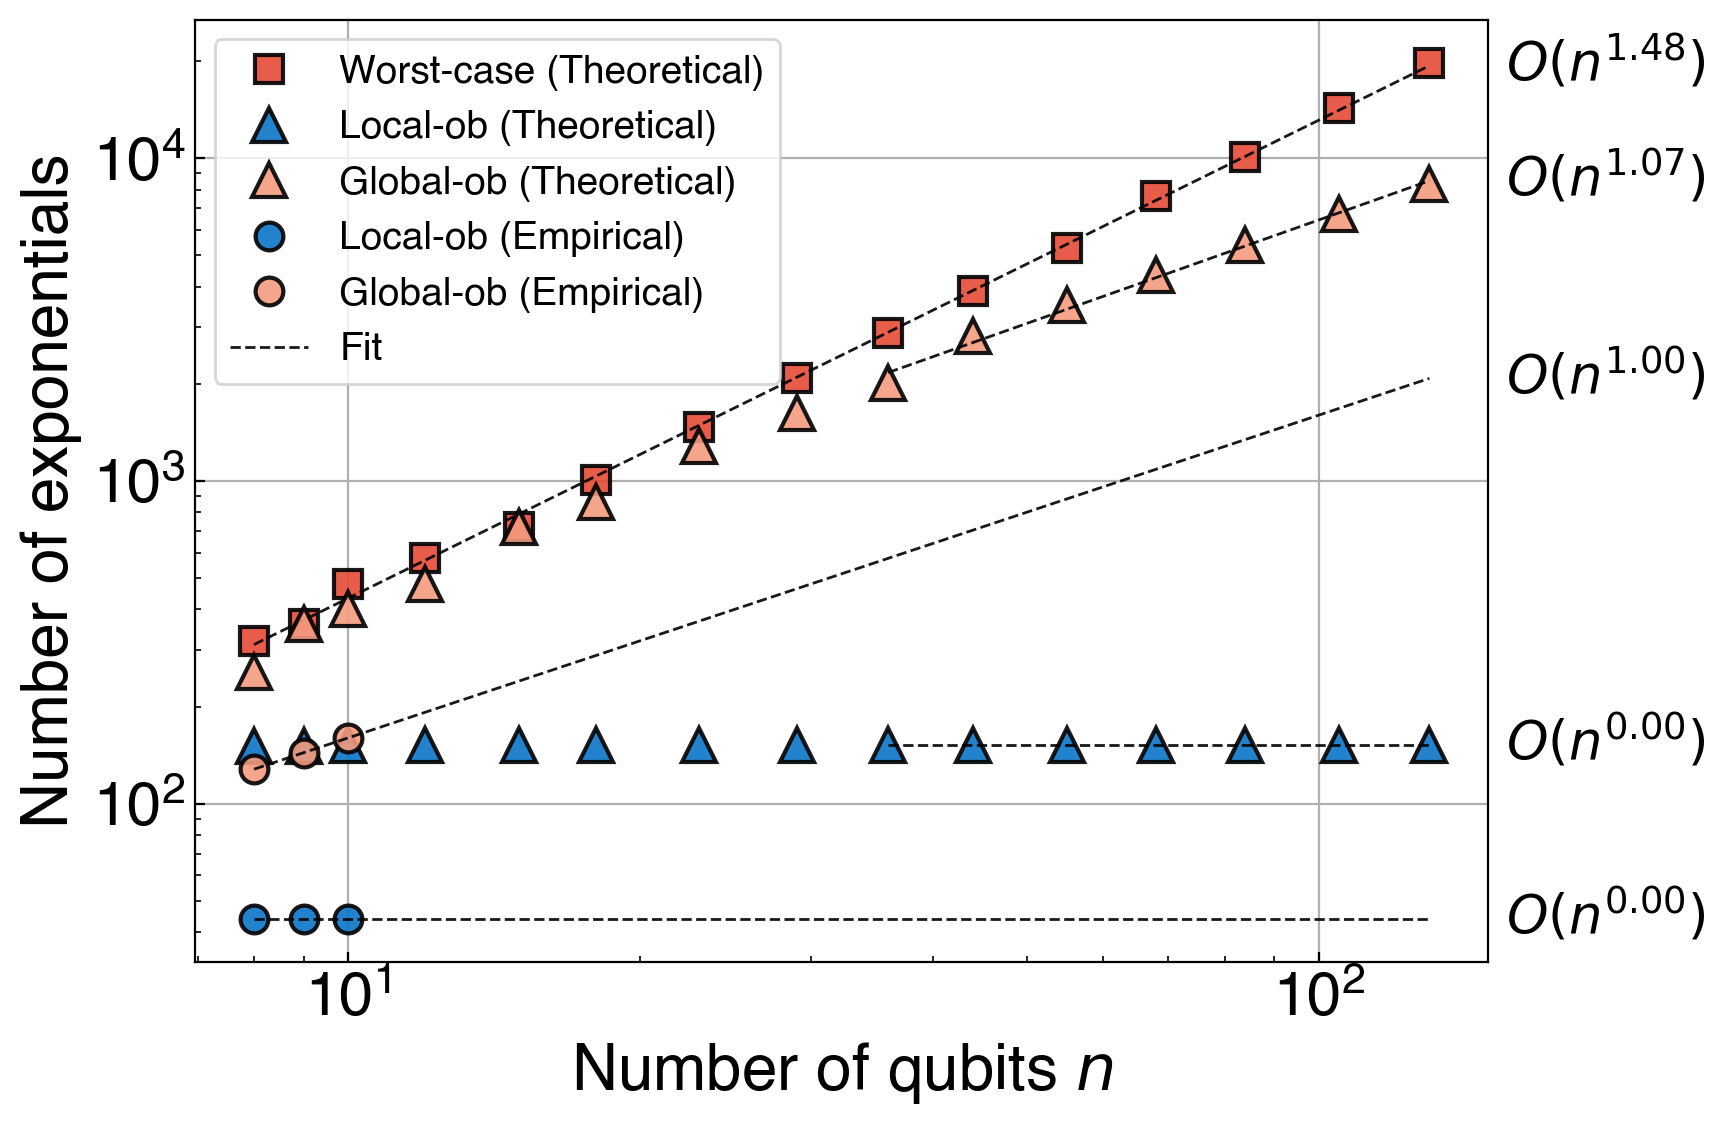

In [68]:
n_list_bnd = n_list_bnd[2:]
cost_st_list = cost_st_list[2:]
cost_lc_list_s = cost_lc_list_s[2:]
cost_lc_list_m = cost_lc_list_m[2:]
n_list_emp = n_list_emp[2:]
cost_em_list_s = cost_em_list_s[2:]
cost_em_list_m = cost_em_list_m[2:]

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10-markersize_shift)

plot_fit(ax2, n_list_bnd[0:], cost_st_list[0:], var=suffix, x_offset=1.20, y_offset=0.9)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color='#0A75C7', label='Local-ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_s[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color='#F39B7FFF', label='Global-ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_m[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color='#0A75C7', label='Local-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.20, y_offset=0.9, ext_x=n_list_bnd)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color='#F39B7FFF', label='Global-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.20, y_offset=0.9, ext_x=n_list_bnd, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel(f'Number of qubits $n$')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog(); 
# ax2.set_xscale('log', base=20)
# ax2.set_yscale('log', base=10)
ax2.grid(); ax2.legend(loc='upper left')

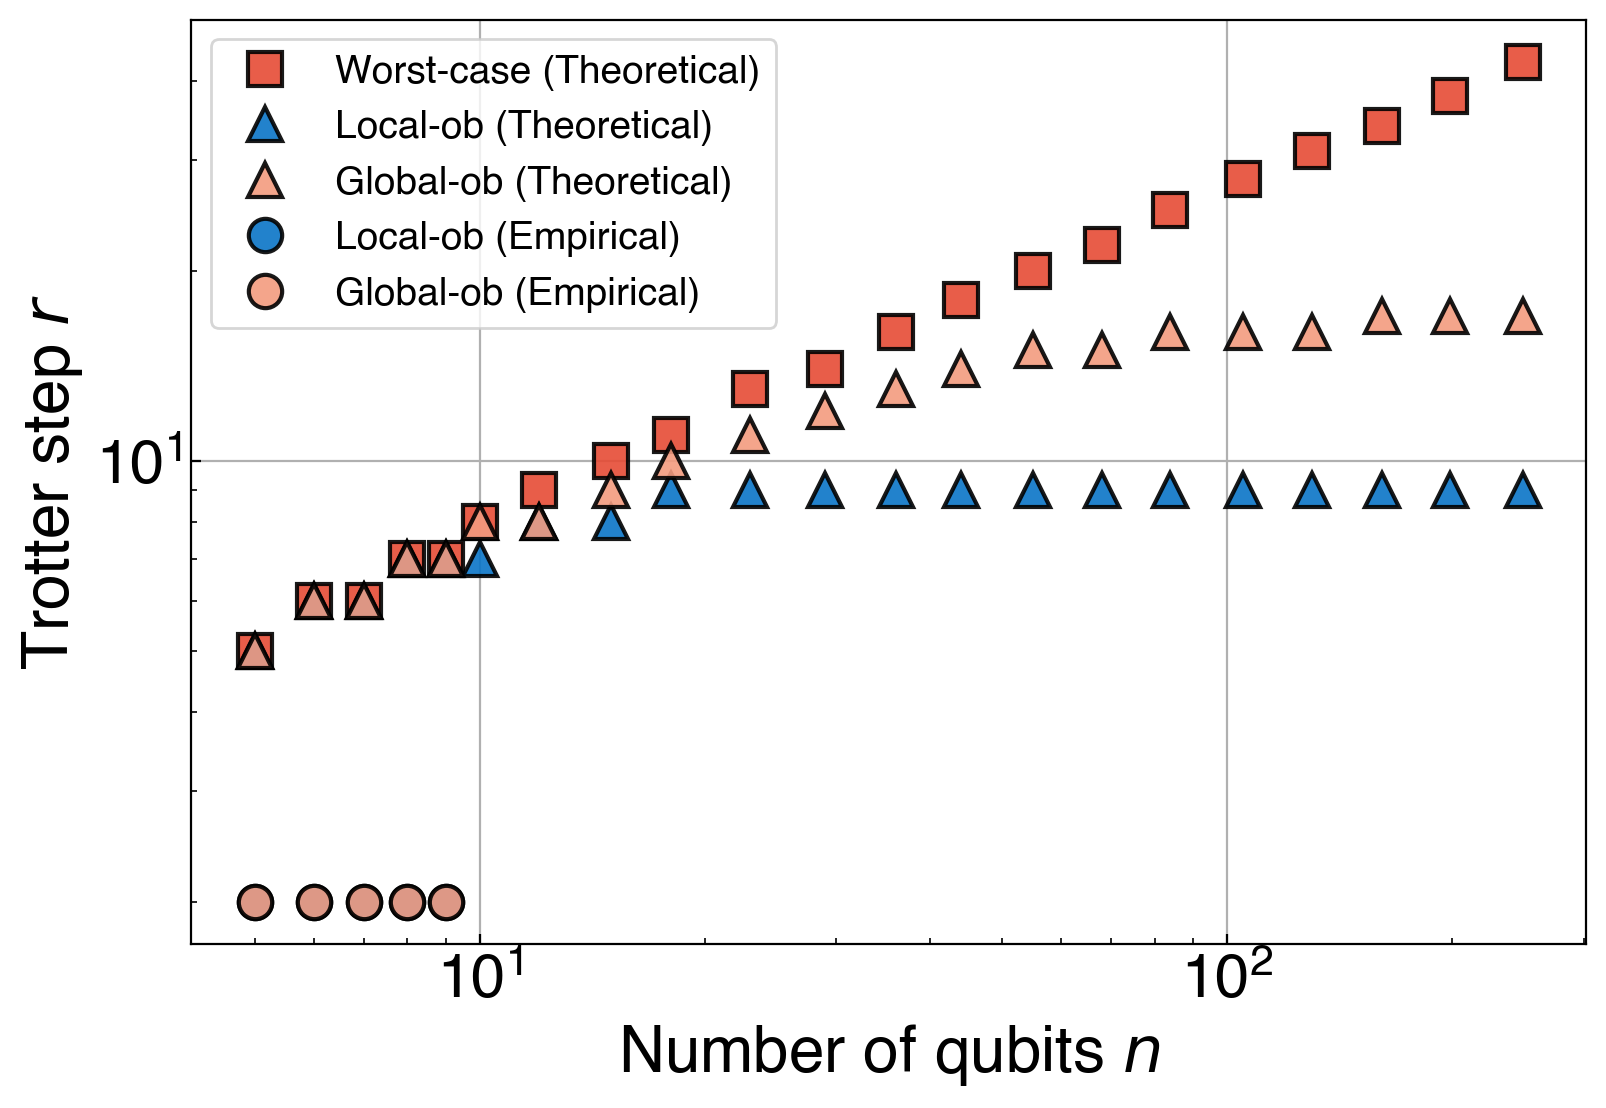

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(bnd_data['n'], bnd_data['worst'], 's', label='Worst-case (Theoretical)')
ax.plot(bnd_data['n'], bnd_data['singl'], '^', label='Local-ob (Theoretical)', color='#0A75C7')
ax.plot(bnd_data['n'], bnd_data['multi'], '^', label='Global-ob (Theoretical)', color='#F39B7FFF')
ax.plot(emp_data['n'], emp_data['singl'], 'o', label='Local-ob (Empirical)', color='#0A75C7')
ax.plot(emp_data['n'], emp_data['multi'], 'o', label='Global-ob (Empirical)', color='#F39B7FFF')

ax.set_xlabel(r'Number of qubits $n$'); ax.set_ylabel(r'Trotter step $r$')
ax.loglog(); ax.legend(); ax.grid()

In [15]:
prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 250 
n_list_bnd = [9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105]
n_max, n_min = 10, 5  #  9, 5 ;  12, 5 
# J, h = 1, 1 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
Jx, Jy, Jz, hx, hy, hz = 1, 0, 0, 0.5, 1.2, 0
t, r = 0.2, 20

field_list = [0 for _ in range(n_bnd_max)]
# field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
n_list_emp = np.arange(n_min, n_max+1)

data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

import multiprocess as mp
PROCESSES = 10
for i, n in enumerate(n_list_bnd):
    print(f'-------------- n (bound) = {n} --------------')
    hnn = Nearest_Neighbour_1d(n, Jx=Jx, Jy=Jy, Jz=Jz, hx=hx, hy=hy, hz=hz, pbc=False, rand_field=field_list)
    bnd_worst_err = measure_error(r, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    bnd_singl_err = measure_error(r, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    bnd_multi_err = measure_error(r, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_zz', n, hnn, 0, 0])

    bnd_data['worst'].append(bnd_worst_err)
    bnd_data['singl'].append(bnd_singl_err)
    bnd_data['multi'].append(bnd_multi_err)

for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    hnn = Nearest_Neighbour_1d(n, Jx=Jx, Jy=Jy, Jz=Jz, hx=hx, hy=hy, hz=hz, pbc=False, rand_field=field_list)
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # magne_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n).to_matrix()
    corre_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    multi_ob = corre_ob
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err = measure_error(r, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err = measure_error(r, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err = measure_error(r, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    emp_data['worst'].append(emp_worst_err)
    emp_data['singl'].append(emp_singl_err)
    emp_data['multi'].append(emp_multi_err)

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
# pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}_error.csv', index=False)
# pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}_error.csv', index=False)
# pd.DataFrame(bnd_data)


-------------- n (bound) = 9 --------------
-------------- n (bound) = 10 --------------
-------------- n (bound) = 12 --------------
-------------- n (bound) = 15 --------------
-------------- n (bound) = 18 --------------
-------------- n (bound) = 23 --------------
-------------- n (bound) = 29 --------------
-------------- n (bound) = 36 --------------
-------------- n (bound) = 44 --------------
-------------- n (bound) = 55 --------------
-------------- n (bound) = 68 --------------
-------------- n (bound) = 84 --------------
-------------- n (bound) = 105 --------------
-------------- n (bound) = 130 --------------
-------------- n (empirical) = 5 --------------
multi ob norm:  4.0
ob error (operator norm, largest eigen):  3.5925153e-05 ; r: 20 ; t: 0.2
ob error (operator norm, largest eigen):  2.7296215e-05 ; r: 20 ; t: 0.2
-------------- n (empirical) = 6 --------------
multi ob norm:  5.0
ob error (operator norm, largest eigen):  3.7576203e-05 ; r: 20 ; t: 0.2
ob error (oper

a_em: 1.0277532782573513; b_em: -8.988506994278778
a_em: 5.381024799184987e-08; b_em: -6.658086893295444
a_em: 0.20488597309198195; b_em: -6.960630978156396


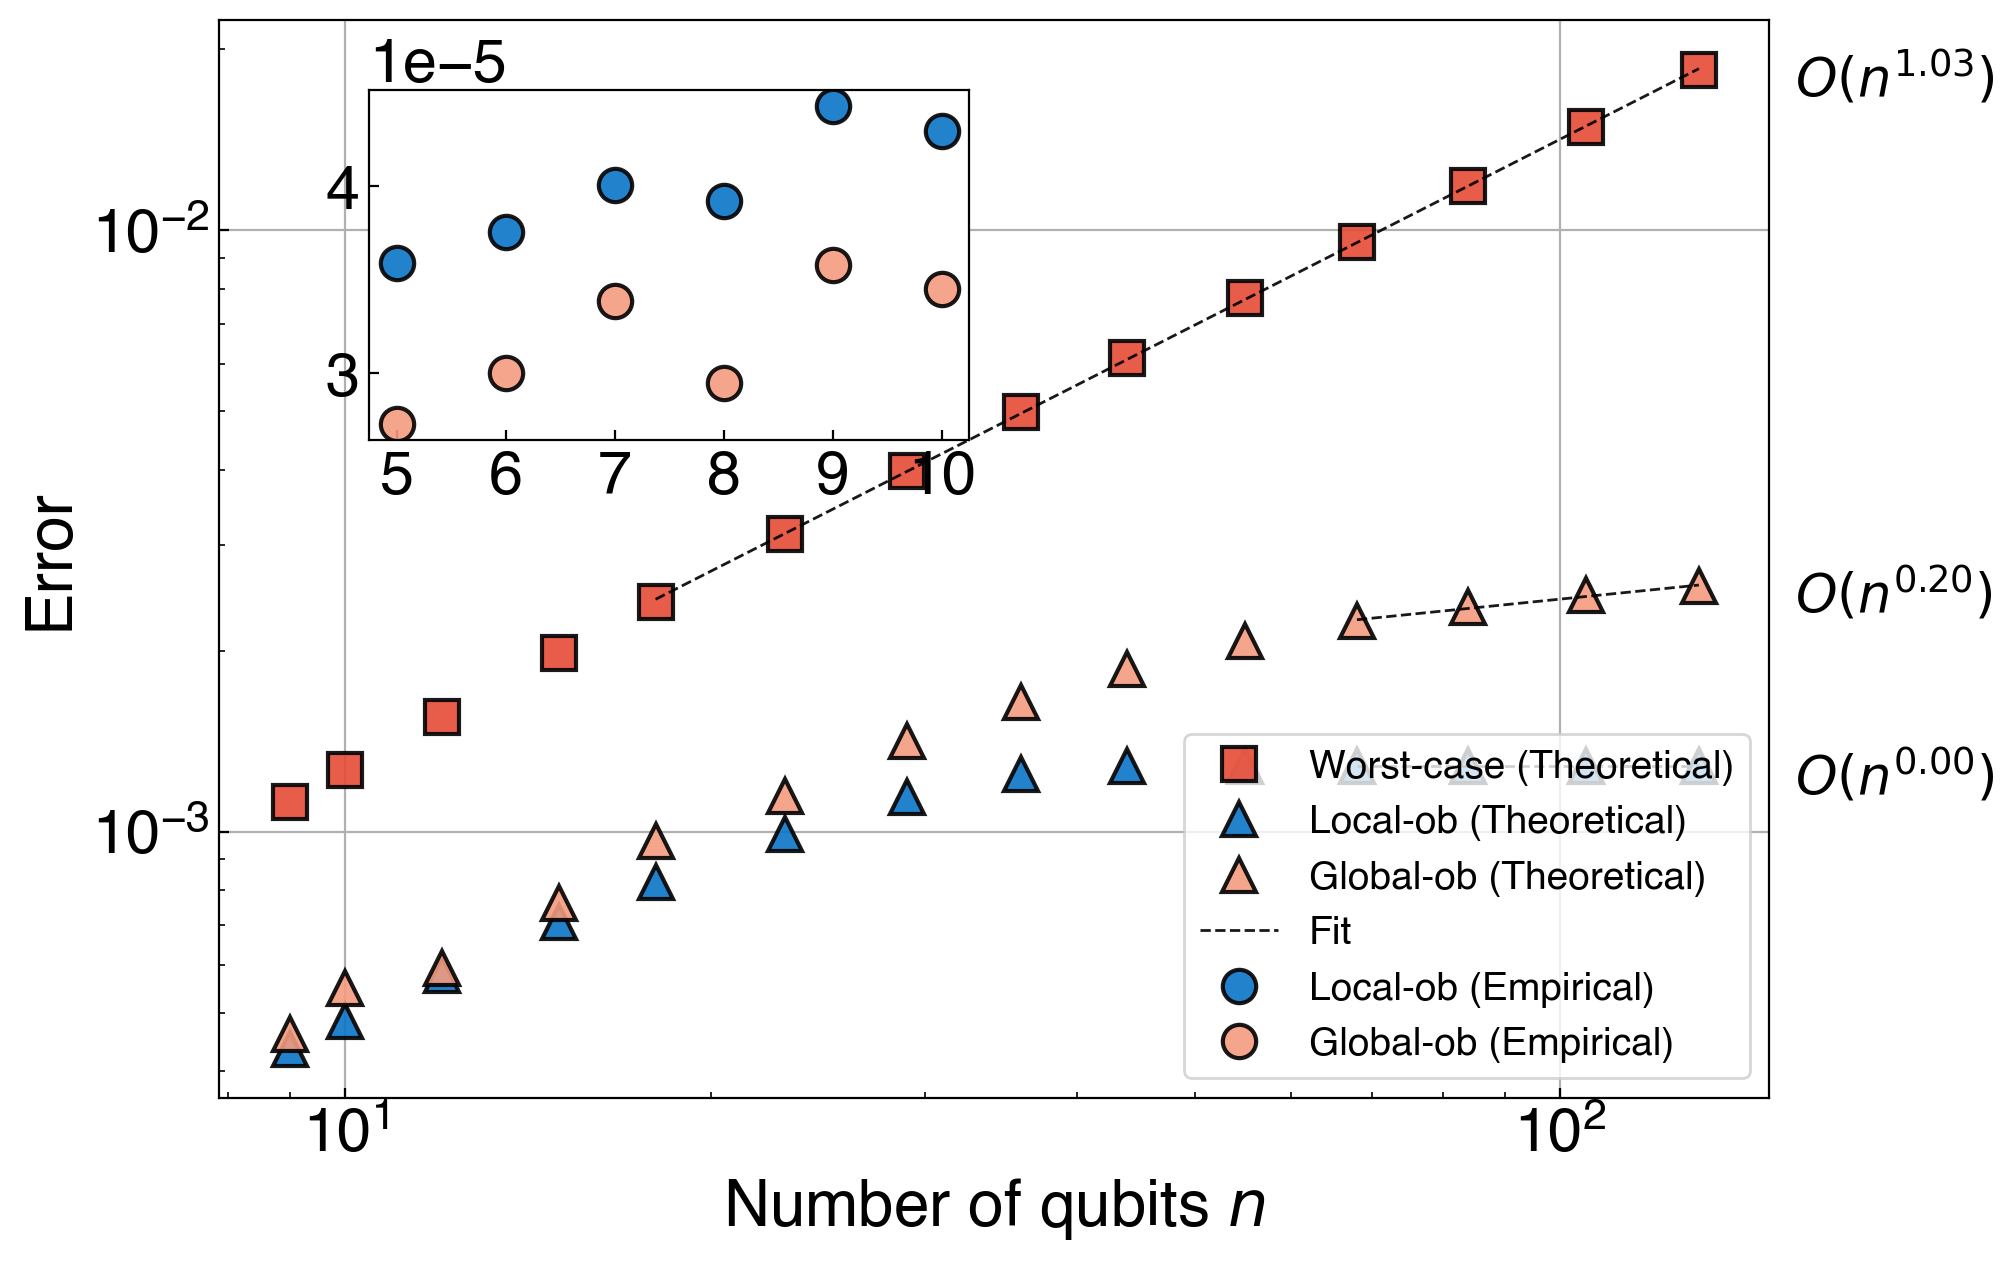

In [16]:
from matplotlib.patches import Patch
mpl.rcParams['lines.markersize'] = 12
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
line1 = ax.plot(bnd_data['n'], bnd_data['worst'], 's', label='Worst-case (Theoretical)')
line2 = ax.plot(bnd_data['n'], bnd_data['singl'], '^', label='Local-ob (Theoretical)', color='#0A75C7')
line3 =ax.plot(bnd_data['n'], bnd_data['multi'], '^', label='Global-ob (Theoretical)', color='#F39B7FFF')
# ax.plot(emp_data['n'], emp_data['singl'], 'o', label='Local-ob (Empirical)', color='#0A75C7')
# ax.plot(emp_data['n'], emp_data['multi'], 'o', label='Global-ob (Empirical)', color='#F39B7FFF')

## inset 
ax_inset = fig.add_axes([0.2, 0.58, 0.30, 0.25])
line4 = ax_inset.plot(emp_data['n'], emp_data['singl'], 'o', label='Local-ob (Empirical)', color='#0A75C7')
line5 = ax_inset.plot(emp_data['n'], emp_data['multi'], 'o', label='Global-ob (Empirical)', color='#F39B7FFF')
# ax_inset.set_xlabel(r'$n$'); ax_inset.set_ylabel(r'Error')

plot_fit(ax, bnd_data['n'][4:], bnd_data['worst'][4:], var=suffix, x_offset=1.20, y_offset=0.9)
plot_fit(ax, bnd_data['n'][-4:], bnd_data['singl'][-4:], var=suffix, x_offset=1.20, y_offset=0.9)
plot_fit(ax, bnd_data['n'][-4:], bnd_data['multi'][-4:], var=suffix, x_offset=1.20, y_offset=0.9, label='Fit')

ax_inset.set_xticks(emp_data['n'])
ax_inset.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax_inset.legend()

# Get the legend handles and labels from both plots
handles, labels = ax.get_legend_handles_labels()
handles_inset, labels_inset = ax_inset.get_legend_handles_labels()

# Combine the handles and labels
all_handles = handles + handles_inset
all_labels = labels + labels_inset

ax.set_xlabel(r'Number of qubits $n$'); ax.set_ylabel(r'Error')
ax.loglog(); ax.grid()
# ax.legend(loc='lower right'); 
ax.legend(all_handles, all_labels, loc='lower right')

## DQPT (Trotter error)

In [2]:
def exp_count_LC(r, n_qubits, n_terms, k=1):
    exp_count = 0
    for i in range(1, r+1):
        # print('i: ', i)
        if i <= int((n_qubits-k)/2):
            exp_count += (3*k + 6 * i) * factor / 2
            # exp_count += (2*factor * i - 1+k) * 2    
            # exp_count += (4 * i - 1) * 2    
        else:
            exp_count += n_terms * 1.5
    return exp_count

# def exp_count_LC(r, n_qubits, n_terms):
#     exp_count = 0
#     for i in range(1, r+1):
#         # print('i: ', i)
#         if i < int(n_qubits/2):
#             exp_count += (2*factor * i - 1) * 2    
#             # exp_count += (4 * i - 1) * 2    
#         elif i == int(n_qubits/2):
#             exp_count += (2*factor * i - 1) * 2  - 1
#         else:
#             exp_count += n_terms * 2
#     return exp_count

In [30]:
print(measure_error(2, None, 1, None, 'lightcone_bound', coeffs=['singl', n, H1d, 0, 0], verbose=True))
print(measure_error(2, None, 1, None, 'lightcone_bound', coeffs=['singl', n, H1d, 0, 2], verbose=True))

0.23666666666666664
0.21


In [6]:
n = 12
t_max, t_n = 3.0, 100
t_list = np.linspace(0, t_max, t_n)
t_search_list = np.linspace(0.1, 3, 100)
# prefix = 'NNH' # 'Heisenberg'
prefix = 'TFI'

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

# PBC is important
if prefix == 'TFI':
    H1d = Heisenberg_1d(n, Jx=0.0, Jy=0.0, Jz=0.2, hx=1.0, pbc=False, verbose=False)
    h_list_xyz = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
elif prefix == 'NNH':
    H1d = Heisenberg_1d(n, Jx=0.2, Jy=0.2, Jz=0.2, hx=1.0, pbc=False, verbose=False)
    h_list_xyz = [H1d.ham_xyz[0], H1d.ham_xyz[1], H1d.ham_xyz[2]]
else:
    raise ValueError('Invalid prefix')


H = H1d.ham
# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[1], H1d.ham_xyz[2]]
h_list = H1d.ham_par

eps = 0.05
gate_lc = 500
k = 3
print('LC Trotter gate: ', gate_lc)
gate_lc_list = [exp_count(r, n, factor, 'LC', k=k) for r in range(50)]
# print('gate_lc_list: ', gate_lc_list)
r_lc_bnd = find_closest_index(gate_lc_list, gate_lc)
lc_error_list = [measure_error(r_lc_bnd, None, t, None, 'lightcone_bound', coeffs=['singl', n, H1d, 0, k-1], verbose=True) for t in t_search_list]
print(list(zip(t_search_list, lc_error_list)))
t_lc_index = find_closest_index(lc_error_list, eps)
t_lc = t_search_list[t_lc_index]
print(f'lightcone time: {t_lc}, lc r: {r_lc_bnd}')

# t_lc = 2.5
# r_start_singl_bnd, r_end, eps = 1, n, 0.005
# print('fixed eps: ', eps, '; t_lc: ', t_lc)
# bnd_singl_err_r = partial(measure_error, h_list=None, t=t_lc, exact_U=None, type='lightcone_bound', coeffs=['singl', n, H1d])
# r_lc_bnd = binary_search_r(r_start_singl_bnd, r_end, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
# print('LC Trotter r: ', r_lc_bnd)
# gate_lc = exp_count_LC(r_lc_bnd, n, factor*n)

r_st_bnd = int(gate_lc / (1.5*factor*n)) + 1
print('standard Trotter r: ', r_st_bnd)
st_error_list = np.array([measure_error(r_st_bnd, h_list_xyz, t, None, 'worst_loose_bound', coeffs=['singl', n, H1d], verbose=True) for t in t_search_list])
print(list(zip(t_search_list, st_error_list)))

# new_error_list = [(error-eps)**2 for error in st_error_list]
# t_st_index = new_error_list.index(min(new_error_list))
# t_st = t_search_list[t_st_index]
# print('st_error_list: ', st_error_list)
t_st_index = find_closest_index(st_error_list, eps)
t_st = t_search_list[t_st_index]
print(f'lightcone time: {t_lc}; standard Trotter t: {t_st}; error = {st_error_list[t_st_index]}')

LC Trotter gate:  500
[(0.1, 8.746666666666667e-06), (0.1292929292929293, 1.8904574253228476e-05), (0.15858585858585858, 3.4884776864313656e-05), (0.18787878787878787, 5.800638821641574e-05), (0.21717171717171718, 8.958852202602843e-05), (0.24646464646464647, 0.00013095029200964515), (0.27575757575757576, 0.0001834108118837595), (0.305050505050505, 0.000248289195364865), (0.33434343434343433, 0.0003269045561694557), (0.36363636363636365, 0.0004205760080140246), (0.3929292929292929, 0.0005306226646150653), (0.42222222222222217, 0.0006583636396890717), (0.45151515151515154, 0.0008051180469525374), (0.4808080808080808, 0.0009722050001219549), (0.51010101010101, 0.0011609436129138197), (0.5393939393939393, 0.0013726529990446242), (0.5686868686868687, 0.001608652272230862), (0.597979797979798, 0.0018702605461890258), (0.6272727272727272, 0.002158796934635612), (0.6565656565656565, 0.0024755805512871112), (0.6858585858585858, 0.00282193050986002), (0.7151515151515151, 0.003199165924070827), 

In [3]:
from qiskit.quantum_info import Statevector, DensityMatrix
import itertools as it
from dqpt import *  

# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
proj0 = [''.join(i) for i in list(it.product(['I', 'Z'], repeat=n))]
k = 3
print('local observables: ', generate_proj_pstrs(n, k)[:2**k])
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in generate_proj_pstrs(n, k)]).simplify()
local_ob = SparsePauliOp.from_list([(pstr, 1/2**k) for pstr in generate_proj_pstrs(n, k)[:2**k]]).simplify()
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in proj0]).simplify()
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in proj0[:4]])
init_state = Statevector.from_label('0'*n)
init_dm = DensityMatrix(init_state).to_operator()
# init_dm
echo_op = SparsePauliOp(proj0, [1j/8]*len(proj0))
echo_op_dt = H @ echo_op - echo_op @ H
echo_op_dt.simplify()
rate_dt_op = (H + echo_op @ H @ echo_op).simplify()

echo_list, echo_pf_list, echo_local_list, echo_local_pf_lc_list, echo_local_pf_st_list = [], [], [], [], []

for i, t in enumerate(t_list):
    if i % 50 == 0: print(i) 
    else: print('+', end='')
    exact_U = expm(-1j * t * H.to_matrix())
    apprx_U_lc = pf_r([h.to_matrix() for h in h_list], t, r_lc_bnd, order=2)
    apprx_U_st = pf_r([h.to_matrix() for h in h_list], t, r_st_bnd, order=2)
    final_state = exact_U @ init_state.data
    final_state_pf_lc = apprx_U_lc @ init_state.data
    final_state_pf_st = apprx_U_st @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    echo_pf = np.abs(init_state.data.conj() @ final_state_pf_lc)**2
    echo_local = final_state.conj() @ local_ob.to_matrix() @ final_state
    echo_local_pf_lc = final_state_pf_lc.conj() @ local_ob.to_matrix() @ final_state_pf_lc
    echo_local_pf_st = final_state_pf_st.conj() @ local_ob.to_matrix() @ final_state_pf_st
    # print('echo: ', echo)
    echo_list.append(echo)
    echo_pf_list.append(echo_pf)
    echo_local_list.append(echo_local.real)
    echo_local_pf_lc_list.append(echo_local_pf_lc.real)
    echo_local_pf_st_list.append(echo_local_pf_st.real)

print('\necho_local_list: ', echo_local_list)
print('echo_local_pf_lc_list: ', echo_local_pf_lc_list)
rate_list = [-1/n*np.log(echo) for echo in echo_list]
rate_pf_list = [-1/n*np.log(echo) for echo in echo_pf_list]
rate_local_list = [-1/n*np.log(echo) for echo in echo_local_list]
rate_local_pf_lc_list = [-1/n*np.log(echo) for echo in echo_local_pf_lc_list]
rate_local_pf_st_list = [-1/n*np.log(echo) for echo in echo_local_pf_st_list]

fig, axes = plt.subplots(1, 1, figsize=(11, 6), layout='tight', sharex=True)

# normalize_factor = sum(rate_list)
# normalize_factor_local = sum(rate_local_list)
# normalize_factor = sum([1.0])
# normalize_factor_local = sum([1.0])
axes.plot(t_list, rate_list, '--', label=rf'Exact (Echo)', c='k')
axes.plot(t_list, rate_local_list, '-', label=rf'Exact (ob)', c='m')
sparse = 3

t_st_index = find_closest_index(t_list, t_st)
axes.plot(t_list[:t_st_index+1][::sparse], rate_local_pf_st_list[:t_st_index+1][::sparse], 's', label=rf'Standard PF2 (ob)', markersize=16, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, t_lc)
axes.plot(t_list[:t_lc_index+1][::sparse], rate_local_pf_lc_list[:t_lc_index+1][::sparse], 'o', label=rf'Lightcone PF2 (ob)', markersize=10, c="#0A75C7FF")

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_pf_lc_list)]
# axes2 = axes.twinx()
# axes2.plot(t_list, np.array(rate_local_pf_st_list)-np.array(rate_local_list), ':', label=rf'Echo', c='k')

axes.axvline(t_c, ls=':', color='k', label=f'Exact $t_c = {t_c:.2f}$')
axes.axvline(t_c_appro, ls=':', color='k', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='m')

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Normalized rate function $r(t)$')
# axes[0].text(-.09, 1.0, f'(a)', transform=axes[0].transAxes, size=24, weight='bold')
# fig.savefig(f'{figs_dir}/rate_function_{prefix}_n={n}_eps={eps}.pdf', bbox_inches='tight')

local observables:  ['IIIIIIIIIIII' 'IIZIIIIIIIII' 'IZIIIIIIIIII' 'IZZIIIIIIIII'
 'ZIIIIIIIIIII' 'ZIZIIIIIIIII' 'ZZIIIIIIIIII' 'ZZZIIIIIIIII']


: 

### Plot every step

In [111]:
from qiskit.quantum_info import Statevector, DensityMatrix
import itertools as it
from dqpt import *  

# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
proj0 = [''.join(i) for i in list(it.product(['I', 'Z'], repeat=n))]
init_state = Statevector.from_label('0'*n)
k = 3
print('local observables: ', generate_proj_pstrs(n, k)[:2**k])
local_ob = SparsePauliOp.from_list([(pstr, 1/2**k) for pstr in generate_proj_pstrs(n, k)[:2**k]]).simplify()

echo_list, echo_pf_list, echo_local_list, echo_local_pf_lc_list, echo_local_pf_st_list = [], [], [], [], []

print('----prepare one step----')
apprx_U_lc_1 = pf_r([h.to_matrix() for h in lc_group(H1d, 0, k-1, 2*n)[:2]], t_lc/r_lc_bnd, 1, order=2)
# apprx_U_lc_1 = pf_r([h.to_matrix() for h in H1d.ham_par], t_lc/r_lc_bnd, 1, order=2)
apprx_U_st_1 = pf_r([h.to_matrix() for h in H1d.ham_xyz], t_st/r_st_bnd, 1, order=2)

for i, t in enumerate(t_list):
    if i % 50 == 0: print(i) 
    else: print('+', end='')
    exact_U = expm(-1j * t * H.to_matrix())
    final_state = exact_U @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    echo_local = final_state.conj() @ local_ob.to_matrix() @ final_state
    # print('echo: ', echo)
    echo_list.append(echo)
    echo_local_list.append(echo_local.real)
    # echo_pf = np.abs(init_state.data.conj() @ final_state_pf_lc)**2
    # echo_pf_list.append(echo_pf)

echo_local_lc_list, echo_local_st_list = [], []
print('\nLC')
for r in range(0, r_lc_bnd+1):
    print('+', end='')
    exact_U_lc = expm(-1j * t_lc/r_lc_bnd * r * H.to_matrix())
    apprx_U_lc = matrix_power(apprx_U_lc_1, r)
    final_state_lc = exact_U_lc @ init_state.data
    final_state_pf_lc = apprx_U_lc @ init_state.data
    echo_local_lc = final_state_lc.conj() @ local_ob.to_matrix() @ final_state_lc
    echo_local_pf_lc = final_state_pf_lc.conj() @ local_ob.to_matrix() @ final_state_pf_lc
    echo_local_pf_lc_list.append(echo_local_pf_lc.real)
    echo_local_lc_list.append(echo_local_lc.real)

print('\nST')
for r in range(0, r_st_bnd+1):
    print('+', end='')
    exact_U_st = expm(-1j * t_st/r_st_bnd * r * H.to_matrix())
    apprx_U_st = matrix_power(apprx_U_st_1, r)
    final_state_st = exact_U_st @ init_state.data
    final_state_pf_st = apprx_U_st @ init_state.data
    echo_local_st = final_state_st.conj() @ local_ob.to_matrix() @ final_state_st
    echo_local_pf_st = final_state_pf_st.conj() @ local_ob.to_matrix() @ final_state_pf_st
    echo_local_pf_st_list.append(echo_local_pf_st.real)
    echo_local_st_list.append(echo_local_st.real)

rate_local_lc_list = [-1/k*np.log(echo) for echo in echo_local_lc_list]
rate_local_st_list = [-1/k*np.log(echo) for echo in echo_local_st_list]

print('\necho_local_list: ', echo_local_list)
print('echo_local_pf_lc_list: ', echo_local_pf_lc_list)
rate_list = [-1/n*np.log(echo) for echo in echo_list]
# rate_pf_list = [-1/n*np.log(echo) for echo in echo_pf_list]
rate_local_list = [-1/k*np.log(echo) for echo in echo_local_list]
rate_local_pf_lc_list = [-1/k*np.log(echo) for echo in echo_local_pf_lc_list]
rate_local_pf_st_list = [-1/k*np.log(echo) for echo in echo_local_pf_st_list]

t_st_list = np.linspace(0, t_st, r_st_bnd+1)
t_lc_list = np.linspace(0, t_lc, r_lc_bnd+1)

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_list)]
dqpt_data = {'t':t_list, 'echo':echo_list, 'echo_local':echo_local_list, 'echo_local_pf_lc':echo_local_pf_lc_list, 'echo_local_pf_st':echo_local_pf_st_list, 'rate':rate_list, 'rate_local':rate_local_list, 'rate_local_pf_lc':rate_local_pf_lc_list, 'rate_local_pf_st':rate_local_pf_st_list, 't_lc':t_lc, 't_st':t_st, 'r_lc_bnd':r_lc_bnd, 'r_st_bnd':r_st_bnd, 'gate_lc':gate_lc, 't_c':t_c, 't_c_appro':t_c_appro, 't_st_list': t_st_list, 't_lc_list': t_lc_list, 'rate_local_lc':rate_local_lc_list, 'rate_local_st':rate_local_st_list}
# dqpt_data
## save as .npy file
np.save(f'{data_dir}/dqpt_{prefix}_n={n}_eps={eps}_t={t_max}.npy', dqpt_data)


local observables:  ['IIIIIIIIIIII' 'IIZIIIIIIIII' 'IZIIIIIIIIII' 'IZZIIIIIIIII'
 'ZIIIIIIIIIII' 'ZIZIIIIIIIII' 'ZZIIIIIIIIII' 'ZZZIIIIIIIII']
----prepare one step----
0
+++++++++++++++++++++++++++++++++++++++++++++++++50
+++++++++++++++++++++++++++++++++++++++++++++++++
LC
++++++++++++++++
ST
+++++++++++++++
echo_local_list:  [1.0, 0.9972486505522122, 0.9890361353168922, 0.9754861220721932, 0.9568016441851426, 0.9332605693383835, 0.9052094465388004, 0.8730558446423805, 0.8372594918858111, 0.7983223515267885, 0.7567779656050582, 0.7131803280164531, 0.6680925822253633, 0.6220758354339514, 0.5756783720894801, 0.5294255323919437, 0.4838104966238298, 0.4392861845624625, 0.39625844206214567, 0.3550806453834868, 0.3160498093994686, 0.27940423989327373, 0.24532272427589494, 0.21392521065799475, 0.18527488369889017, 0.15938150829129888, 0.1362058800252441, 0.1156651954114886, 0.09763913571219851, 0.08197644635811069, 0.0685017895072442, 0.05702265024505421, 0.047336086917256374, 0.039235132570

Text(0.5, 0, 'Simulation Time $t$')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


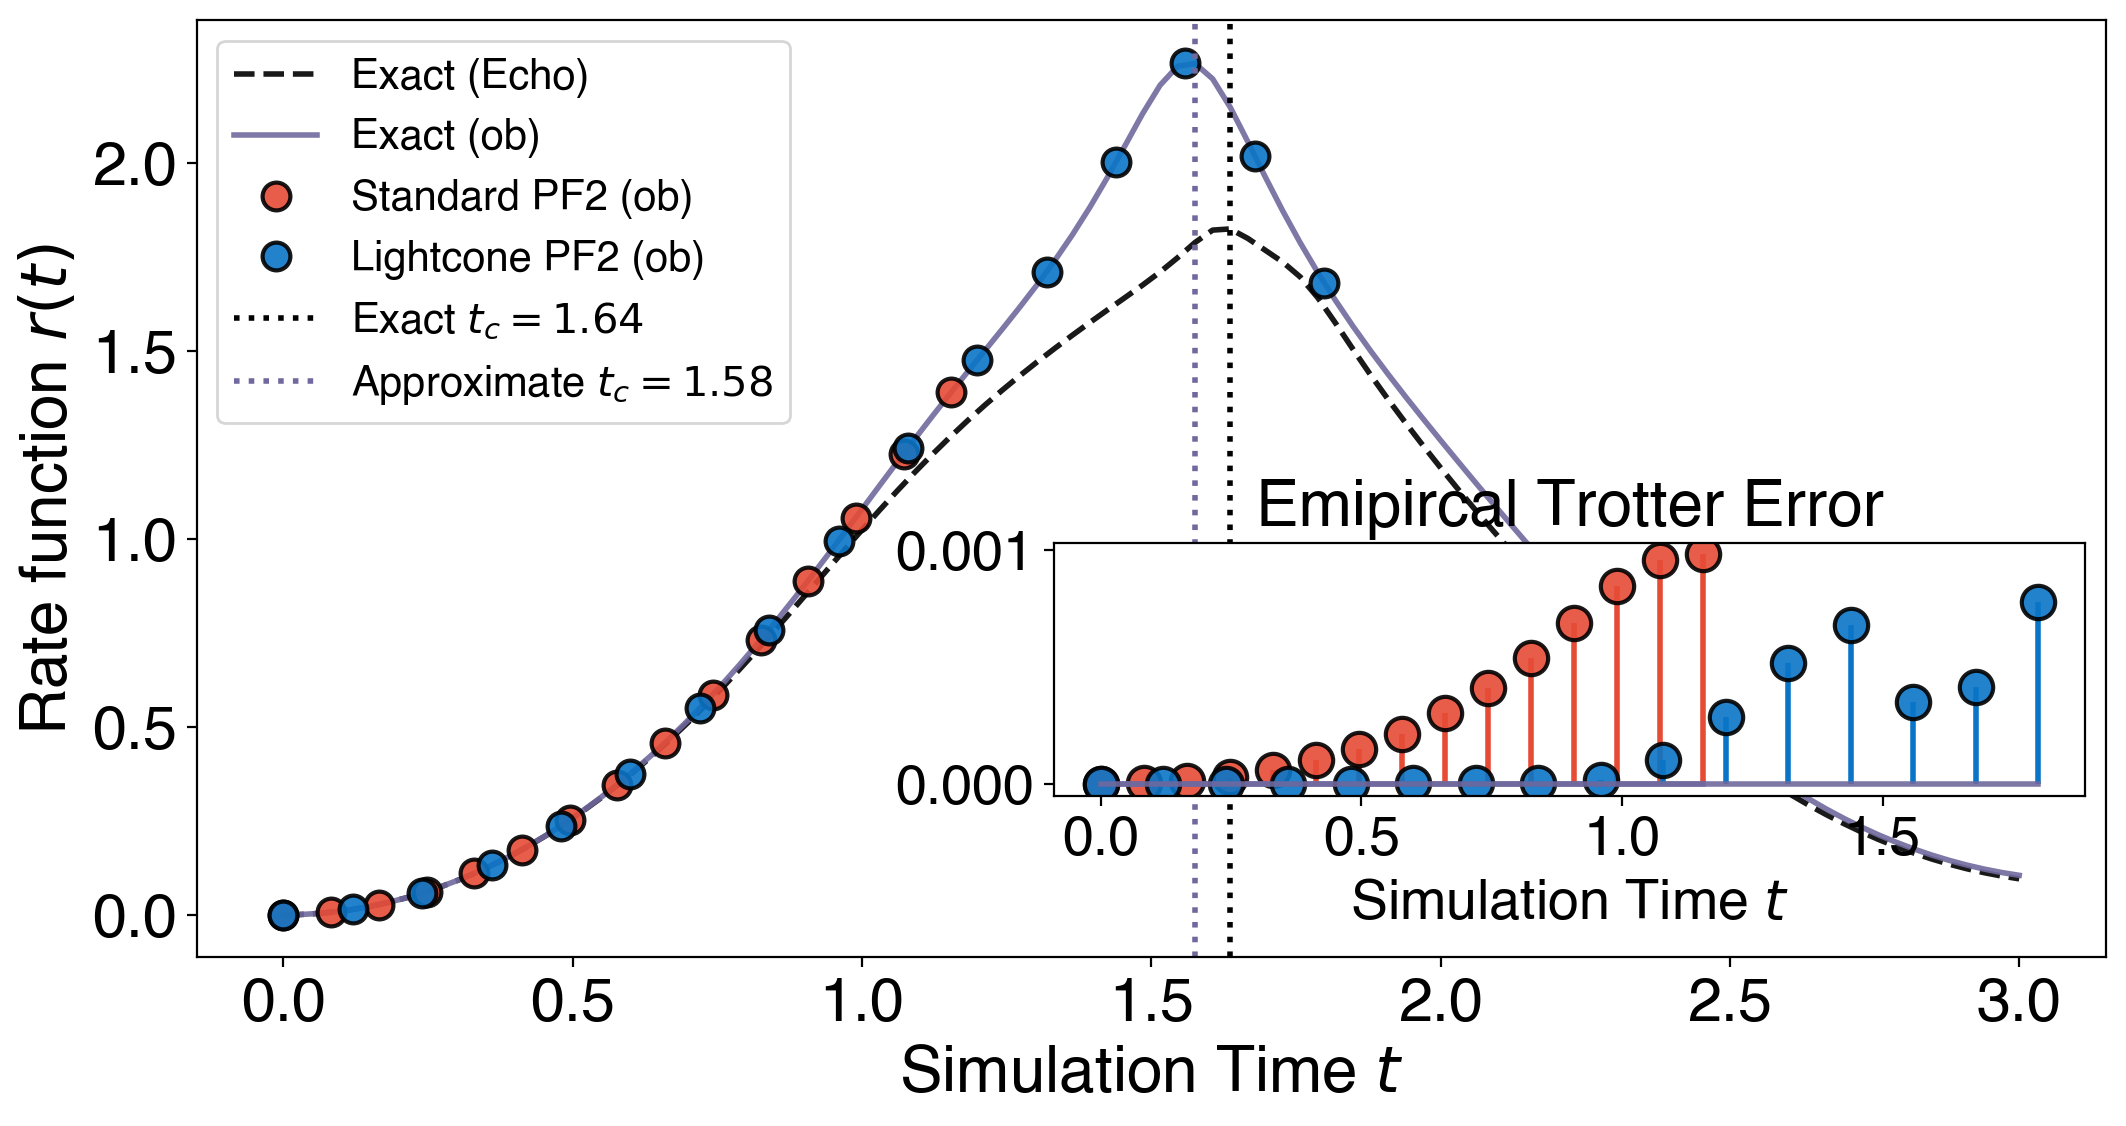

In [10]:
dqpt_data = np.load(f'{data_dir}/dqpt_{prefix}_n={n}_eps={eps}_t={t_max}.npy', allow_pickle=True).item()

plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
fig, axes = plt.subplots(1, 1, figsize=(11, 6), layout='tight', sharex=True)

# normalizer1, normalizer2 = sum(rate_list[::10]), sum(rate_local_list[::10])
axes.plot(dqpt_data['t'], dqpt_data['rate'], '--', label=rf'Exact (Echo)', c='k')
axes.plot(dqpt_data['t'], dqpt_data['rate_local'], '-', label=rf'Exact (ob)', c='#70699eFF')
# sparse = 4

t_st_index = find_closest_index(dqpt_data['t'], dqpt_data['t_st'])
axes.plot(dqpt_data['t_st_list'], dqpt_data['rate_local_pf_st'], 'o', label=rf'Standard PF2 (ob)', markersize=10, c="#E64B35FF")
t_lc_index = find_closest_index(dqpt_data['t'], dqpt_data['t_lc'])
axes.plot(dqpt_data['t_lc_list'], dqpt_data['rate_local_pf_lc'], 'o', label=rf'Lightcone PF2 (ob)', markersize=10, c="#0A75C7FF")

t_c, t_c_appro = dqpt_data['t_c'], dqpt_data['t_c_appro']
axes.axvline(t_c, ls=':', color='k', label=f'Exact $t_c = {t_c:.2f}$')
axes.axvline(t_c_appro, ls=':', color='k', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='#70699eFF')

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Rate function $r(t)$')

axes2 = inset_axes(axes, width="60%", height="30%", loc='lower right',  bbox_to_anchor=(0.1, 0.15, 0.9, 0.9), bbox_transform=axes.transAxes)

## inset of axes[1]
axes2.stem(dqpt_data['t_st_list'], abs(np.array(dqpt_data['rate_local_st'])-np.array(dqpt_data['rate_local_pf_st'])), '.', label=rf'ST', markerfmt='C0o', linefmt='C0-', basefmt='C4-')
axes2.stem(dqpt_data['t_lc_list'], abs(np.array(dqpt_data['rate_local_lc'])-np.array(dqpt_data['rate_local_pf_lc'])), '.', label=rf'LC', markerfmt='C2o', linefmt='C2-', basefmt='C4-')

# axes2.set_yticks([0.0000, 0.0001, 0.0002])
axes2.tick_params(axis='y', labelsize=MEDIUM_SIZE+5)
axes2.tick_params(axis='x', labelsize=MEDIUM_SIZE+5)

axes2.set_title('Emipircal Trotter Error', fontsize=MEDIUM_SIZE+8); 
axes2.set_xlabel('Simulation Time $t$', fontsize=MEDIUM_SIZE+5)

Text(0, 0.5, 'Normalized rate function $r(t)$')

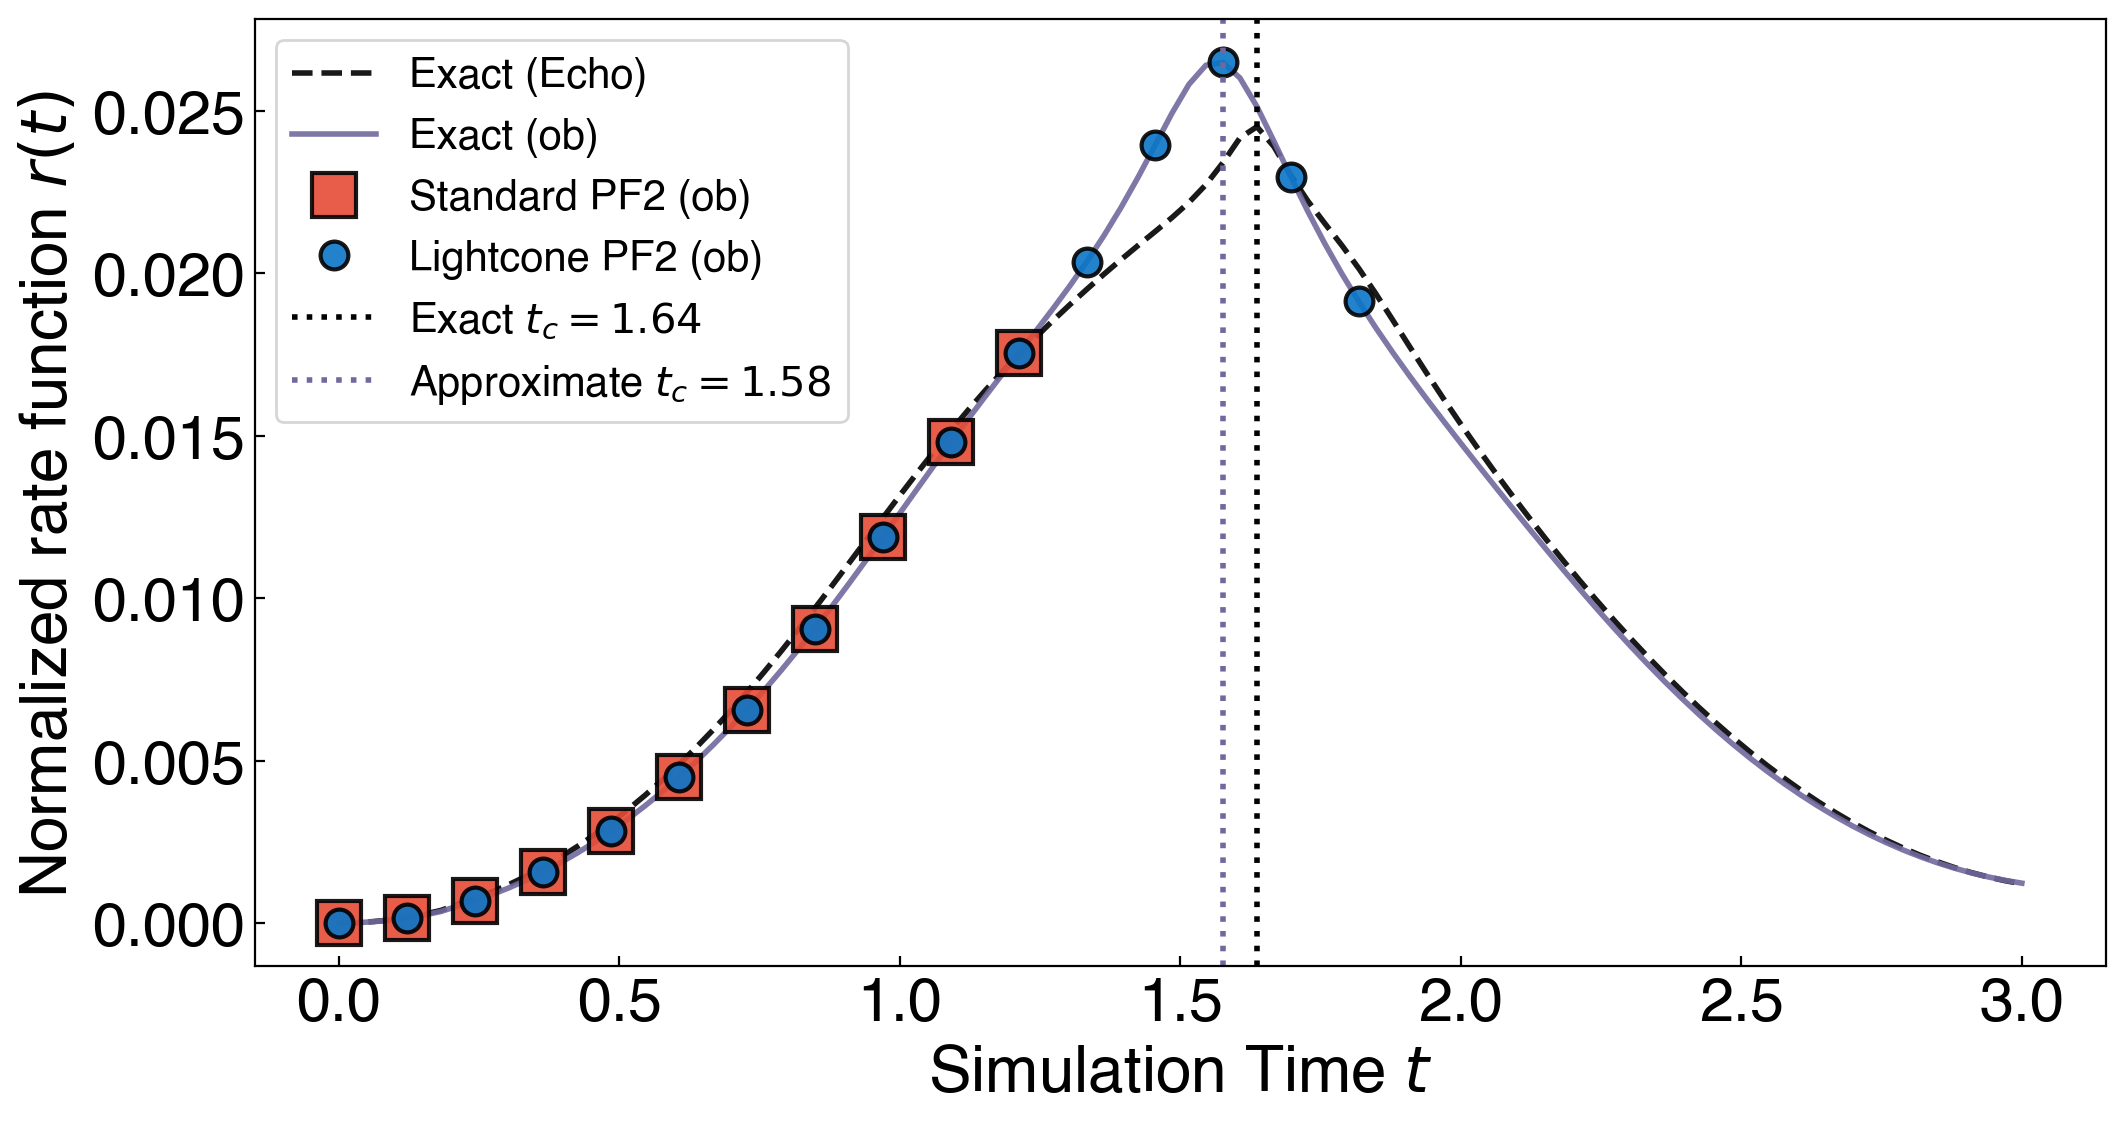

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(11, 6), layout='tight', sharex=True)

# def normalizer(lst):
#     return lst/ sum(lst)

axes.plot(t_list, rate_list/sum(rate_list), '--', label=rf'Exact (Echo)', c='k')
axes.plot(t_list, rate_local_list/sum(rate_local_list), '-', label=rf'Exact (ob)', c='#70699eFF')
sparse = 4

t_st_index = find_closest_index(t_list, t_st)
axes.plot(t_list[:t_st_index+1][::sparse], rate_local_pf_st_list[:t_st_index+1][::sparse]/sum(rate_local_pf_st_list), 's', label=rf'Standard PF2 (ob)', markersize=16, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, t_lc)
axes.plot(t_list[:t_lc_index+1][::sparse], rate_local_pf_lc_list[:t_lc_index+1][::sparse]/sum(rate_local_pf_lc_list), 'o', label=rf'Lightcone PF2 (ob)', markersize=10, c="#0A75C7FF")

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_pf_lc_list)]
# axes2 = axes.twinx()
# axes2.plot(t_list, np.array(rate_local_pf_st_list)-np.array(rate_local_list), ':', label=rf'Echo', c='k')

axes.axvline(t_c, ls=':', color='k', label=f'Exact $t_c = {t_c:.2f}$')
axes.axvline(t_c_appro, ls=':', color='k', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='#70699eFF')

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Normalized rate function $r(t)$')

## Merge figures

bnd_data:      worst  singl  multi    n
0       6      4      5    6
1       7      4      5    7
2       7      4      5    8
3       8      5      5    9
4       8      5      6   10
5       9      5      6   12
6      10      5      6   15
7      11      5      7   18
8      13      5      7   23
9      15      5      8   29
10     16      5      8   36
11     18      5      8   44
12     20      5      9   55
13     22      5      9   68
14     25      5      9   84
15     28      5      9  105
16     31      5      9  130
17     34      5      9  161
18     38      5      9  198
19     43      5      9  248
20     48      5      9  310
emp_data:     worst  singl  multi   n
0      3      2      2   6
1      3      2      2   7
2      3      2      2   8
3      4      2      2   9
4      4      2      2  10
5      4      2      2  11
6      4      2      2  12
a_em: 1.5189982949407244; b_em: 2.69958514699717
a_em: 1.0; b_em: 3.988984046564274
a_em: 1.4699942077226077e-08; b_em: 5.34

/var/folders/zc/9k4hbf5n07d86qpnf8lqkw3w0000gn/T/ipykernel_68429/1953284132.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{figs_dir}/lightcone_NNH1d_merge.pdf', bbox_inches='tight')
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


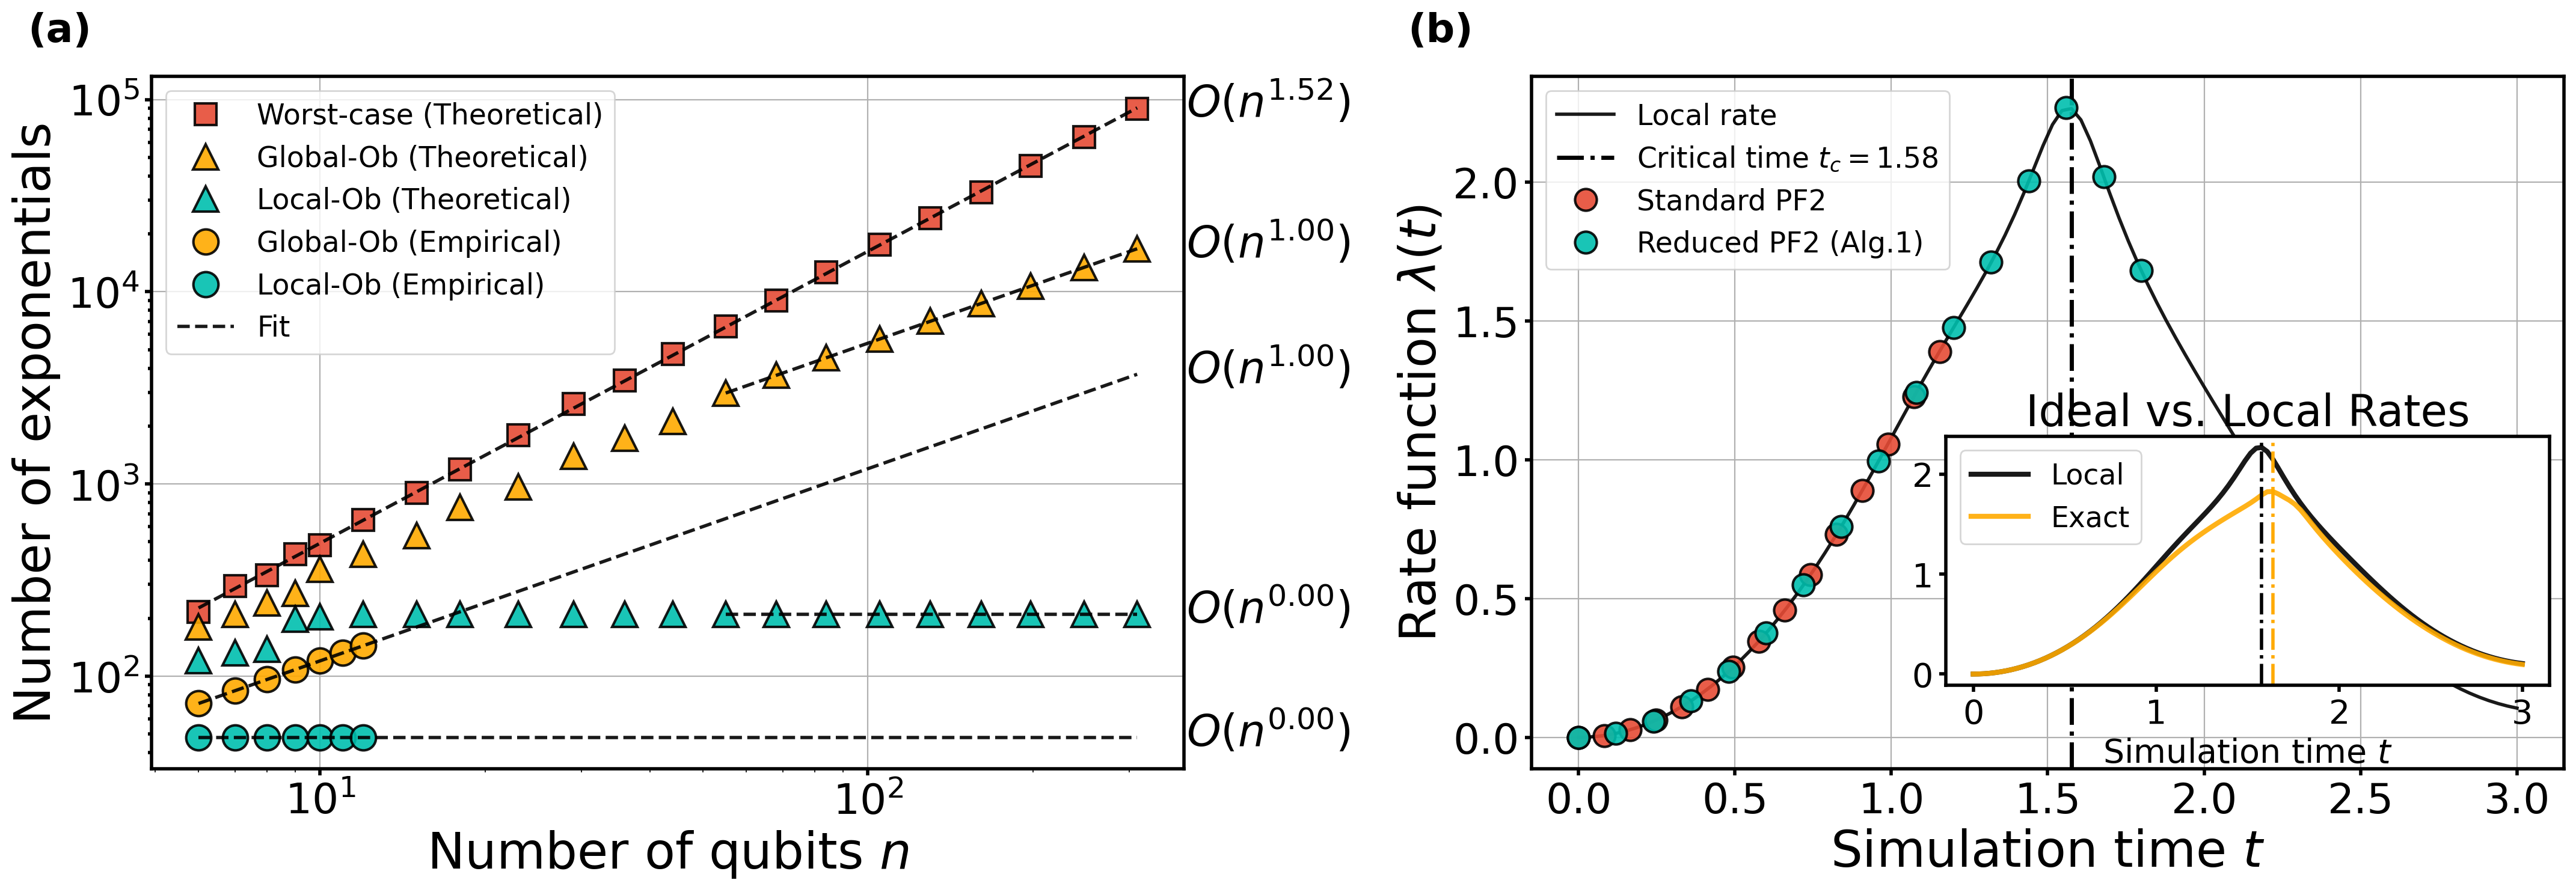

In [50]:
plt.rc('font', size=LARGE_SIZE+6)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE+2)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE+10)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE+5)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE+5)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE+2)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE) 
markersize_shift = -3
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 10
plt.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['xtick.major.width'] = 2.0
mpl.rcParams['ytick.major.width'] = 2.0
mpl.rcParams['ytick.minor.width'] = 2.0
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

new_color = ["#E64B35FF", "#00BFAEFF", "#0A75C7FF", "#F39B7FFF", "#4DBBD5FF", "#FFAA00FF", "k"]
# new_color = ["#E64B35FF", "#47B167FF", "#0A75C7FF", "#F39B7FFF", "#4DBBD5FF", "#FFAA00FF", "k", "#00BFAEFF", '#7272EBFF', '#00CCBFFF', "#70699eFF"]
color_cycle = ["#E64B35FF", "#00BFAEFF", "#0A75C7FF", "#F39B7FFF", "k", "#4DBBD5FF", "#FFAA00FF"]
# color_cycle = ["#E64B35FF", "#47B167FF", "#0A75C7FF", "#F39B7FFF", "k", "#4DBBD5FF", "#FFAA00FF"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', prop_cycle=colors)

prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 400 # 400,  100,  200,  250
n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198, 248, 310]
r_max = n_bnd_max
n_max, n_min = 12, 6  #  9, 5 ;  12, 5 
t, eps = 0.1, 0.001

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
print('bnd_data: ', bnd_data)
print('emp_data: ', emp_data)

cost_st_list = [exp_count(r, bnd_data['n'][i], factor, 'ST') for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count(r, bnd_data['n'][i], factor, 'LC') for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [exp_count(r, bnd_data['n'][i], factor, 'ST') for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count(r, emp_data['n'][i], factor, 'LC') for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [exp_count(r, emp_data['n'][i], factor, 'ST') for i, r in enumerate(emp_data['multi'])]
cost_em_list_w =  [exp_count(r, emp_data['n'][i], factor, 'ST') for i, r in enumerate(emp_data['worst'])]

fig, axes = plt.subplots(1, 2, figsize=(22, 8), layout='tight', gridspec_kw={'width_ratios': [1, 1.0]})
import matplotlib.gridspec as gridspec

# Create a figure
# fig = plt.figure(figsize=(20, 7), layout='tight')

# # Define a gridspec with 1 row and 2 columns, with width ratios of 2:1
# gs = gridspec.GridSpec(1, 2, width_ratios=[5, 7]) 
# axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
# ob_string = 'XIII'
axes[0].plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10-markersize_shift)
plot_fit(axes[0], n_list_bnd[0:], cost_st_list[0:], var=suffix, x_offset=1.23, y_offset=0.9)
# # axes[0].plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
axes[0].plot(n_list_bnd, cost_lc_list_m, '^', color=new_color[5], label='Global-Ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(axes[0], n_list_bnd[-9:], cost_lc_list_m[-9:], var=suffix, x_offset=1.23, y_offset=0.9)
axes[0].plot(n_list_bnd, cost_lc_list_s, '^', color=new_color[1], label='Local-Ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(axes[0], n_list_bnd[-9:], cost_lc_list_s[-9:], var=suffix, x_offset=1.23, y_offset=0.9)
# plot_fit(axes[0], n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
# axes[0].plot(n_list_emp, cost_em_list_w, 'D', color='#E64B35FF', label=r'Worst-case (Empirical)', markersize=10)
axes[0].plot(n_list_emp, cost_em_list_m, 'o', color=new_color[5], label='Global-Ob (Empirical)', markersize=12-markersize_shift)
plot_fit(axes[0], n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.23, y_offset=0.9, ext_x=n_list_bnd)
axes[0].plot(n_list_emp, cost_em_list_s, 'o', color=new_color[1], label='Local-Ob (Empirical)', markersize=12-markersize_shift)
plot_fit(axes[0], n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.23, y_offset=0.9, ext_x=n_list_bnd, label='Fit')
# axes[0].plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
axes[0].set_xlabel(f'Number of qubits $n$')
axes[0].set_ylabel('Number of exponentials')
# axes[0].set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
axes[0].loglog(); 
# axes[0].set_xscale('log', base=20)
# axes[0].set_yscale('log', base=10)
axes[0].grid(); axes[0].legend(loc='upper left')


prefix, eps = 'TFI', 0.05
## read from .npy file
dqpt_data = np.load(f'{data_dir}/dqpt_{prefix}_n={n}_eps={eps}_t={t_max}.npy', allow_pickle=True).item()
t_list = dqpt_data['t']
t_c_appro = dqpt_data['t_c_appro']
t_lc_list = dqpt_data['t_lc_list']
t_st_list = dqpt_data['t_st_list']
# normalizer1, normalizer2 = sum(dqpt_data['rate'][::10]), sum(dqpt_data['rate_local'][::10])
# axes[1].plot(t_list, dqpt_data['rate']/normalizer1, '--', label=rf'Echo (Ideal)', c='k')
axes[1].plot(t_list, dqpt_data['rate_local'], '-', label=rf'Local rate', c='k')
# sparse = 4

axes[1].axvline(t_c_appro, ls='-.', color='k', label=f'Critical time $t_c = {t_c_appro:.2f}$', c='k', linewidth=2.5)
t_st_index = find_closest_index(t_list, dqpt_data['t_st'])
axes[1].plot(t_st_list, dqpt_data['rate_local_pf_st'], 'o', label=rf'Standard PF2', markersize=10-markersize_shift, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, dqpt_data['t_lc'])
axes[1].plot(t_lc_list, dqpt_data['rate_local_pf_lc'], 'o', label=rf'Reduced PF2 (Alg.1)', markersize=10-markersize_shift, c=new_color[1])
axes[1].grid()

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

t_c = t_list[np.argmax(dqpt_data['rate'])]
t_c_appro = t_list[np.argmax(dqpt_data['rate_local'])]
# axes2 = axes[1].twinx()
axes2 = inset_axes(axes[1], width="65%", height="40%", loc='lower right',  bbox_to_anchor=(0.1, 0.1, 0.9, 0.9), bbox_transform=axes[1].transAxes)
# axes2 = inset_axes(axes[1], width="40%", height="30%", loc='upper right')
# from matplotlib.ticker import ScalarFormatter

## inset of axes[1]
# axes2.stem(t_st_list, abs(np.array(echo_local_st_list)-np.array(echo_local_pf_st_list)), '.', label=rf'ST', markerfmt='C0o', linefmt='C0-', basefmt='C4-')
# axes2.stem(t_lc_list, abs(np.array(echo_local_lc_list)-np.array(echo_local_pf_lc_list)), '.', label=rf'LC', markerfmt='C1o', linefmt='C1-', basefmt='C4-')
# axes2.plot()
axes2.plot(t_list, np.array(dqpt_data['rate_local']), '-', label=rf'Local', c='k', linewidth=3)
axes2.plot(t_list, dqpt_data['rate'], '-', label=rf'Exact', c=color_cycle[-1], linewidth=3)
t_c = t_list[np.argmax(dqpt_data['rate'])]
t_c_appro = t_list[np.argmax(dqpt_data['rate_local'])]
axes2.legend(loc='upper left'); 
axes2.axvline(t_c, ls='-.', label=f'Exact $t_c = {t_c:.2f}$', c=color_cycle[-1])
axes2.axvline(t_c_appro, ls='-.', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='k')

axes2.set_yticks([0, 1, 2])
axes2.tick_params(axis='y', labelsize=MEDIUM_SIZE+5)
axes2.tick_params(axis='x', labelsize=MEDIUM_SIZE+5)

# axes2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# axes2.set_ylabel('Emipircal Trotter Error'); 
axes2.set_title('Ideal vs. Local Rates', fontsize=MEDIUM_SIZE+11); 
# axes2.set_title('Empirical Error', fontsize=MEDIUM_SIZE+12); 
axes2.set_xlabel('Simulation time $t$', fontsize=MEDIUM_SIZE+5)

# axes[1].axvline(t_c, ls=':', color='k', label=f'Ideal $t_c = {t_c:.2f}$')

axes[1].legend(loc='upper left'); axes[1].set_xlabel('Simulation time $t$'); axes[1].set_ylabel('Rate function $\lambda(t)$')
axes[0].annotate('(a)', xy=(-0.12, 1.05), xycoords='axes fraction', fontsize=24, weight='bold', color='k')
axes[1].annotate('(b)', xy=(-0.12, 1.05), xycoords='axes fraction', fontsize=24, weight='bold', color='k')
fig.savefig(f'{figs_dir}/lightcone_NNH1d_merge.pdf', bbox_inches='tight')